This Notebook is a library of functions for numerics of the incoherence simulations.

In [ ]:
using BSON: @load
using Flux
using Flux: params
using Flux.Optimise
using Flux.Optimise: update!
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Zygote
using FFTW
using Distributions
using SparseArrays
using JLD

In [78]:
"""
    optimise(init_z, loss, opt, tolerance, [out_toggle = 0,][max_iter = 1_000_000])

    Optimization that stops when the gradient is small enough
"""
function optimise(opt, z, loss; tolerance, out_toggle, max_iter = 500_000)
    tol2 = tolerance^2
    ps = params(z)
    iter=1
    while true
        if iter > max_iter
            @warn "Max num. iterations reached"
            return nothing
        end
        grads = gradient(loss, ps) #loss cannot have any arguments
        update!(opt, ps, grads)
        succ_error = sum(abs2, grads[z])
        if out_toggle != 0 && iter % out_toggle == 0
            println("====> In Gradient: Iteration: $iter grad_size: $(sqrt(succ_error)) tolerance: $tolerance  error: ", string(sqrt(loss())))
        end
        if succ_error < tol2
            break
        end
        iter += 1
    end
    return z
end

optimise

In [79]:
evaluate_recovery(model, )

UndefVarError: UndefVarError: evaluate_recovery not defined

In [61]:
z = randn(10)
measurements = randn(12)
W = randn(12,10)
model(vec) = W*vec
loss(params_vec) = sum(abs2, measurements - model(params_vec))
opt = Descent()
optimise(opt, z, () -> loss(z), tolerance=1e-4)

UndefKeywordError: UndefKeywordError: keyword argument out_toggle not assigned

In [62]:
opt = Optimise.Descent(0.001) 
z = randn(10)
measurements = randn(12)
W = randn(12,10)
model(vec) = W*vec
ps = params(z)
loss(params_vec) = sum(abs2, measurements - model(vec))
tolerance = 1e-4
out_toggle = 0
max_iter = 500_000
tol2 = tolerance^2
iter=1
grads = gradient(() -> loss(ps), ps)
# while succ_error > tol2 
#         if iter > max_iter
#             @warn "Max num. iterations reached"
#             return nothing
#         end
#         grads = gradient(() -> loss(ps), ps)
#         update!(opt, ps, grads)
#         succ_error = sum(abs2, grads[z])
#         if out_toggle != 0 && iter % out_toggle == 0
#             println("====> In Gradient: Iteration: $iter grad_size: $(sqrt(succ_error)) tolerance: $tolerance  Loss: ", string(loss(z)))
#         end
#         iter += 1
#     end


MethodError: MethodError: no method matching *(::Matrix{Float64}, ::typeof(vec))
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:560
  *(::StridedMatrix{T}, !Matched::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real} at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/matmul.jl:44
  *(::StridedMatrix{var"#s814"} where var"#s814"<:Union{Float32, Float64}, !Matched::StridedMatrix{var"#s813"} where var"#s813"<:Union{Float32, Float64, ComplexF32, ComplexF64}) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/LinearAlgebra/src/matmul.jl:158
  ...

In [64]:
function sample_fourier(aimed_m, n)
    F = dct(diagm(ones(n)),2)
    sampling = rand(Bernoulli(aimed_m/n), n)
    true_m = sum(sampling)
    return (true_m, F[sampling,:]* sqrt(n/true_m)) # normalize it
end
function fourier(dim)
    dct(diagm(ones(dim)),2)
end

fourier (generic function with 1 method)

In [68]:
function subspace_incoherence(F, A)
    α = 0
    m, _ = size(A)
    QR_decomp = qr(A)
    for i in 1:m
        temp = norm(Matrix(QR_decomp.Q)'*F[i,:], 2)
        α = max(α, temp)
    end
    return α
end

subspace_incoherence (generic function with 1 method)

In [74]:
function recover_signal(measurements, measure, model, code_dim)
    function loss(signal_guess)
        return sum(abs2, measure(signal_guess) - measurements)
    end
    
    opt_code = optimise( Flux.Optimise.Descent(4e-5), loss, init=randn(code_dim)/sqrt(code_dim), tolerance=1e-6, out_toggle=20000)
    
    return opt_code != nothing ? model(opt_code) : nothing
end

recover_signal (generic function with 1 method)

In [75]:
β=0.5
k=32
mid = 64
n = 128
desired_m = 64
F = fourier(n)
k̂ = randn(k)/sqrt(k)
ps = Flux.params(k̂)
m, A = sample_fourier(desired_m, n)
model = Chain(
        Dense(k, mid, relu, bias = false; init =(out,in) -> randn(out,in)/sqrt(out)),
        Dense(mid, n, bias = false; init =(out,in) -> β*randn(out,in)/sqrt(out) + (1-β) * F[:,1:in])
    )
W₁ = Flux.params(model)[1]
W₂ = Flux.params(model)[2]
x₀ = model(randn(k)/sqrt(k))
modele() = model(k̂)
y= A*x₀
function loss()
    return sum(abs2, A*model(k̂) - y)
end

opt = Flux.Optimise.Descent(0.001)
out_log = 500_000
num_data = 5
tolerance = 4e-4
tol2 = tolerance^2
results = [[],[]]
max_iter = 500_000

for β in 0:0.1:1
    for i in 1:num_data
        W₁ .= randn(mid,k)
        W₂ .= β*randn(n,mid)/sqrt(n) + (1-β) * F[:,1:mid]
        i=1
        inco = matrix_alignment(W₂, F)
        
        optimise(opt,)
        
        while true
            i+=1
            gs = gradient( ps) do
                sum(abs2, A*model(k̂) - y)
            end
            update!(opt, ps,gs)
            if sum(abs2, gs[k̂]) < tol2
               push!(results[1], inco)
                push!(results[2], norm(model(k̂) - x₀))
                println("pushed result, error $(norm(model(k̂) - x₀)), incoherence $inco")
                break
            end
            if i > max_iter
                println("skipping train")
                break
            end
            i % out_log != 0 || @debug "loss: $(loss()), grad: $(sum(abs2, gs[k̂])), error: $(norm(model(k̂) - x₀))"
        end
    end
end
@debug "norm error is $(norm(model(k̂) - x₀))"

ErrorException: invalid redefinition of constant model

In [76]:
scatter(results[1], results[2])

UndefVarError: UndefVarError: results not defined

In [61]:
β=0.5
k=32
mid = 64
n = 128
desired_m = 80
F = fourier(n)
k̂ = randn(k)/sqrt(k)
ps = Flux.params(k̂)
m, A = sample_fourier(desired_m, n)
model = Chain(
        Dense(k, mid, relu, bias = false; init =(out,in) -> randn(out,in)/sqrt(out)),
        Dense(mid, n, bias = false; init =(out,in) -> β*randn(out,in)/sqrt(out) + (1-β) * F[:,1:in])
    )
W₁ = Flux.params(model)[1]
W₂ = Flux.params(model)[2]
x₀ = model(randn(k)/sqrt(k))
modele() = model(k̂)
y= A*x₀
function loss()
    return sum(abs2, A*model(k̂) - y)
end

opt = Flux.Optimise.Descent(0.001)
out_log = 10000
num_data = 5
tolerance = 4e-6
tol2 = tolerance^2
results = [[],[]]
max_iter = 500_000

W₁ .= randn(mid,k)
W₂ .= β*randn(n,mid)/sqrt(n) + (1-β) * F[:,1:mid]
i=1
inco = matrix_alignment(W₂, F)

opt

while true
         i+=1
    gs = gradient( ps) do
            sum(abs2, A*model(k̂) - y)
    end
    update!(opt, ps,gs)
    if sum(abs2, gs[k̂]) < tol2
    push!(results[1], inco)
                push!(results[2], norm(model(k̂) - x₀))
                println("pushed result, error $(norm(model(k̂) - x₀)), incoherence $inco")
                break
            end
            if i > max_iter
                println("skipping train")
                break
            end
            i % out_log != 0 || println("loss: $(loss()), grad: $(norm(gs[k̂])), error: $(norm(model(k̂) - x₀))")
  end

loss: 0.19069825800476656, grad: 0.0002665354924225208, error: 0.5091490975780901
loss: 0.19065269400739113, grad: 0.0002179459969456966, error: 0.509132001931581
loss: 0.1906776960242943, grad: 0.00043216373102096035, error: 0.509106659892179
loss: 0.19065514212367163, grad: 0.00027273163015454943, error: 0.5090657342665227
loss: 0.19064715100166038, grad: 0.00027177870967742324, error: 0.5090064923538545
loss: 0.19074739604526808, grad: 0.00045060363211546375, error: 0.5089552841353363
loss: 0.19076680528773282, grad: 0.0009055768067544585, error: 0.5095214371459466
loss: 0.190741615131089, grad: 0.0006476667813688257, error: 0.5095446436605321
loss: 0.19074620776924905, grad: 0.0001886521109714545, error: 0.508859281831471
loss: 0.19077676029999194, grad: 0.000742405748065938, error: 0.5095114801603651
loss: 0.19077375455694304, grad: 0.000802408974960393, error: 0.5094949139992587
loss: 0.19071531875466002, grad: 0.00024467275880756873, error: 0.5093783594269561
loss: 0.19069585241

LoadError: InterruptException:

In [39]:
results

2-element Vector{Vector{Any}}:
 [1.0000000000000002, 1.0000000000000002, 0.9942659371457384, 0.9959623561747436, 0.9931823810834856, 0.9941219735457206, 0.9717515916958956, 0.9838672395538788, 0.9777176600713909, 0.9810250064106377  …  0.7305789158590728, 0.7967836202406579, 0.7374595817063231, 0.7264824248248138, 0.7738522422224655, 0.7331029388714448, 0.7642969394195752, 0.7881124875129153, 0.746176168268236, 0.7431969021985918]
 [0.4238719166444773, 0.746121552148901, 0.591502828097277, 0.4924743355891634, 0.325576176750969, 0.4754218971988643, 0.576623921023499, 0.32062770712562, 0.32205242092702796, 0.6972299599272646  …  0.5000814495074147, 0.3319987524589201, 0.46951464437297336, 0.6889947057832015, 1.516733840323634, 0.5650658618180159, 0.3212102642971756, 0.5181258865207554, 0.4252844491763594, 0.6817183255728844]

In [ ]:
k=12
mid=15
n=50
aimed_m = 20

x₀ = model(randn(k)/sqrt(k))
m, A = sample_fourier(aimed_m, n)
y = A*x₀
println("signal norm: ", norm(x₀))
println("with measurements norm: ", norm(y))
x̂ = recover_signal(y, x -> A*x, model, k)
#println("recovered: ", x̂, " with measurements ", A*x̂)
println("norm of the error: ", norm(x̂ - x₀))
println("norm of recovered: ", norm(x̂))
#does not seem to work with gaussian.

In [ ]:
size(A)

In [112]:
function recovery_error(x₀, model, A, k)
    y = A*x₀
    x̂ = recover_signal(y, x -> A*x, model, k)
    if x̂ == nothing
        return nothing
    end
    return norm(x̂ - x₀)
end

recovery_error (generic function with 1 method)

In [122]:
k=15
mid=20
n=100
aimed_m = 35
plot_pairs = []
m, A = sample_fourier(aimed_m, n)
F = fourier(n)
W₁ = randn(mid, k)/sqrt(mid)
β=0.5
model = Chain(
        Dense(k, mid, relu, bias = false; init =(out,in) -> randn(out,in)/sqrt(out)),
        Dense(mid, n, I, bias = false; init =(out,in) -> β*randn(out,in)/sqrt(out) + (1-β) * F[:,1:in])
    )



Chain(
  Dense(15 => 20, relu; bias=false),    # 300 parameters
  Dense(20 => 100, UniformScaling{Bool}(true); bias=false),  # 2_000 parameters
) 

In [126]:
Flux.params(model)

Params([[0.00014177412729451383 -0.28278208239562747 … 0.34099851485182303 -0.11937219579573191; -0.3895810074855248 0.22259853425085346 … 0.25046148078423336 0.07928074480358631; … ; -0.16178405297115492 -0.498002227280967 … 0.4291426291479408 -0.2126396494000069; 0.11365651332188732 0.007388117940947938 … 0.249921189885099 0.3414077158704079], [-0.03150998455764323 0.12806804870264005 … -0.0615064100634827 0.04820680622814488; 0.012210641461380567 0.10458322117050275 … 0.04205990368966982 0.09076932418423025; … ; 0.02149001606284909 -0.07483381678307247 … 0.01875778611938514 -0.03781216199226888; 0.08176090346717065 -0.0170483677264531 … 0.0959891521421396 -0.08205273881889778]])

In [133]:
β_array = 0:0.5:1
num_trials = 2
k=15
mid=20
n=100
aimed_m = 35
plot_pairs = []
m, A = sample_fourier(aimed_m, n)
F = fourier(n)
W₁ = randn(mid, k)/sqrt(mid)
model = Chain(
        Dense(k, mid, relu, bias = false; init =(out,in) -> W₁),
        Dense(mid, n, I, bias = false; init =(out,in) -> β*randn(out,in)/sqrt(out) + (1-β) * F[1:out,:])
    )

ps = Flux.params(model)


for alignment in β_array
    signal_errors = []
    for i in 1:num_trials
        x₀ = randn(n)/sqrt(n)
        push!(signal_errors, recovery_error(x₀, model, A, k))
    end
    push!(plot_pairs, (alignment, copy(signal_errors)))
end


LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(100), Base.OneTo(20)), b has dims (Base.OneTo(100), Base.OneTo(100)), mismatch at 2")

In [166]:
gs = gradient( ps) do
    sum(abs2, A*model(k̂) - y)
end

Grads(...)

16-element Vector{Float64}:
  0.30027702283359187
  0.2977076782005569
 -0.08949439964775133
  0.016656954688092633
 -0.08932800903729907
  0.004374925532441641
  0.11108238090805175
 -0.11955577437375853
  0.11398397851865089
  0.02836328637681522
  0.004936957659845073
  0.11228908125099814
  0.15181775914691267
 -0.11135247035411971
  0.06926501873263716
 -0.057461113802936406

In [55]:
function experiment_1()
    β_array = 0:0.05:1
    num_signals = 10
    k=8
    mid=16
    n= 32
    aimed_m = 16
    plot_pairs = []
    m, A = sample_fourier(aimed_m, n)
    for (model, alignment) in get_aligned_models(k, mid,n, β_array)
        signal_errors = []
        for i in 1:num_signals
            x₀ = randn(n)/sqrt(n)
            push!(signal_errors, recovery_error(x₀, model, A, k))
        end
        push!(plot_pairs, (alignment, copy(signal_errors)))
    end
    return plot_pairs
end

experiment_1 (generic function with 1 method)

In [ ]:
plot_pairs = experiment_1()

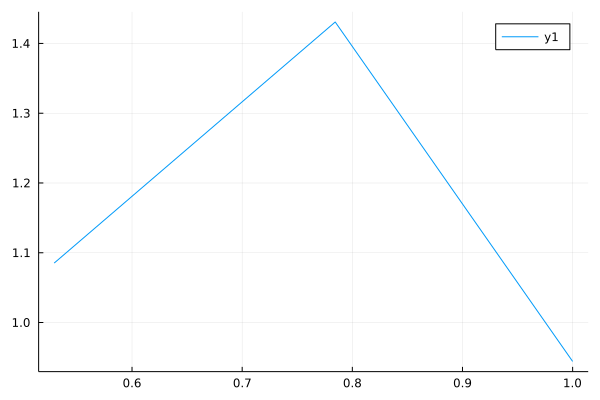

In [23]:
plot([(plot_pair[1], mean(plot_pair[2])) for plot_pair in plot_pairs])

In [ ]:
function get_fourier_meas_fn(m,n)
    true_m, meas_mat = sample_fourier(m, n)
    meas_mat = sqrt(n/true_m).*meas_mat
    return (meas_mat, x -> meas_mat*x)
end

In [ ]:
k = 1
mid = 1
n = 1
aimed_m = 1
num_signals = 2
meas_fn = get_fourier_meas_fn(aimed_m, n)[2]

β_array = [1.0]
plot_pairs = []
signal_errors = Array{Float64}(undef,num_signals)
#model, alignment = get_aligned_models(k, mid, n, [0,])[1]
model = get_rand_model(k,mid,n)
x₀ = randn(n)/sqrt(n)
measurements = meas_fn(x₀)

In [ ]:
measurements = meas_fn(x₀)
println(measurements)
x̂ = recover_signal(measurements, meas_fn, model, k)
println(meas_fn(x̂))
println(err,"   ", norm(x₀))

In [ ]:
model()

In [ ]:
k = 20
mid = 30
n = 100
aimed_m = 20
num_signals = 2
meas_fn = get_fourier_meas_fn(aimed_m, n)
β_array = 0:0.1:1
plot_pairs = []
signal_errors = Array{Float64}(undef,num_signals)
for (model, alignment) in get_aligned_models(k, mid,n, β_array)
    for i in 1:num_signals
        x₀ = randn(n)/sqrt(n)
        signal_error[i] = recovery_error(x₀, model, meas_fn, k)
    push!(plot_pairs, (alignment, mean(signal_errors)))
    end
end

In [ ]:
a = Array{Int}(undef,3)

In [ ]:
k = 20
n = 100
A = randn(n, k)
F = dct(diagm(ones(n)),2)
matrix_alignment(A, F)

In [ ]:
function plot_alignments()
    n= 500
    alignments = []
    normal_one = []
    F = dct(diagm(ones(n)),2)
    for k in 1:2:100
        A = randn(n, k)
        push!(alignments, matrix_alignment(A, F))
        push!(normal_one, sqrt(k/n))
    end
    plot(alignments)
    plot!(normal_one*0.9)
    xlabel!
    
end
plot_alignments()

In [ ]:
k = 20
n = 100
A = randn(n, k)
F = dct(diagm(ones(n)),2)
get_aligned_models

In [ ]:
for i in eachcol(A)
    println(i)
end

In [ ]:
F = dct(diagm(ones(n)),2)

In [ ]:
convert(Array,0:0.1:1.0)

In [ ]:
k = 20
mid = 100
n = 400
aimed_m = 23
num_meas, measure_mat = sample_fourier(aimed_m, n)
measure(x) = measure_mat*x
random_model = get_rand_model(k,mid,n)
#signal in range
true_signal = random_model(rand(Float64, k))
measurements = measure(true_signal);

In [ ]:
#@time recovered_signal = recover_signal(measurements, measure, random_model, k)
#println("The distance between signals is ", norm(recovered_signal - true_signal))
#println("The size of the true signal is ", norm(true_signal))

In [ ]:
function GD_CS(G, y, A, max_iter, stepsize, tolerance, out_toggle)
    _, k = size(Flux.params(G)[1])
    z = randn(k)
    iter = 1
    succ_error = 1
    d(z) = gradient(z -> norm(y - A*G(z))^2, z)[1]

    while iter <= max_iter && succ_error > tolerance
        # d gives the PLUGIn direction
        z -= stepsize * d(z)
        succ_error = norm(stepsize * d(z))
        if iter % out_toggle == 0  
            println("====> In Gradient: Iteration: $iter Successive error: $succ_error")
        end
        iter += 1
    end
    return z
end

In [ ]:
function get_aligned_model()

In the next experiment, we consider a one hidden layer network of the form $G(z) = A_2σ(A_1z)$. The inner layer matrix $A_1 \in \mathbb{R}^{n_1\times k}$ has $\mathcal{N}(0,1/n_1)$ entries. For the outer layer matrix $A_2 \in \mathbb{R}^{n_2\times n_1}$ ($n_2 = n$), we take a matrix $A_{21}$ which contains columns randomly subsampled (without replacement) from a $n\times n$ DCT matrix and a random matrix $A_{22}$ which contains $\mathcal{N}(0,1/n_2)$ entries and take its convex combination, i.e. 
$$A_2 = \beta A_{21} + (1-\beta) A_{22}$$
for $\beta \in [0,1]$.

For each $\beta \in [0.7,1]$, we attempt to recover the code vector $z_0$ from measurement of the form $y = A G(z_0)$ where $A \in \mathbb{R}^{m\times n}$ is subsampled DCT matrix (without replacement) by solve the least squares optimzation problem using the gradient descent algorithm. We show the results from 20 trials for each $\beta$ and for all trials, $z_0, A_1, A_{21}$, and $A_{22}$ are fixed. For all experiments, $k = 20, n = 400$, $n_1$ is approximately 100, and $m$ is approximately 160.

In [ ]:
#setup a synthetic problem
x_dim = 400
k = 20

# F = real(fft(diagm(ones(x_dim)),2))
F = dct(diagm(ones(x_dim)),2)

# sampling rows of DCT matrix for outer layer
sampling = rand(Bernoulli(100/x_dim), x_dim)
sampling = convert.(Int, sampling)
ndm1 = sum(sampling) #number of neurons n_1
nnzindex = []
for i in 1:length(sampling)
    if sampling[i] != 0
        push!(nnzindex, i)
    end
end

A = F[nnzindex,:]' # subsampled DCT
B = randn(x_dim, ndm1)/sqrt(x_dim) #random matrix thats used in convex combination

W1 = randn(ndm1, 20)/sqrt(ndm1) #random inner layer weight matrix

I(x) = x
z = randn(k) # ground code vector

β_list = .7:.01:1
trials = 20
recovery_error_matrix = zeros(length(β_list))
recon_error_matrix = zeros(length(β_list))
α_list = []

for trial in 1:trials
    recovery_error_list = []
    recon_error_list = []   
    α_list = []
    for β in β_list
        Aint = β*A + (1-β) * B

        #setup the generative network 
        G = Chain(
            Dense(20, ndm1, relu, bias = false; init =(out,in) -> W1),
            Dense(ndm1, x_dim, I, bias = false; init =(out,in) -> Aint)
        )

        # subsampling DCT for measurement matrix
        sampling = rand(Bernoulli(.4), x_dim)
        sampling = convert.(Int, sampling)
        m = sum(sampling)
        nnzindex = []
        for i in 1:length(sampling)
            if sampling[i] != 0
                push!(nnzindex, i)
            end
        end
        F_sub = F[nnzindex,:]*sqrt(x_dim)/sqrt(m)

        # measurement vector using subsampled DCT matrix
        y = F_sub*G(z)

        stepsize = .5
        tolerance = 1e-14
        max_iter = 2000
        out_toggle = 2001

        # run gradient descent to solve the least squares problem
        z_rec = GD_CS(G,y,F_sub, max_iter, stepsize, tolerance, out_toggle)
        recov_error = norm(z - real(z_rec))/norm(z)
        recon_error = norm(G(z) - G(real(z_rec)))/norm(G(z))
        Fn = F  
        α = maximum(sum((Fn*Aint)' .* (Fn*Aint)', dims = 1) ./ sqrt.(sum((Fn*Aint*Aint')' .* (Fn*Aint*Aint')', dims = 1)))

        # save results
        push!(recovery_error_list, recov_error)
        push!(recon_error_list, recon_error)
        push!(α_list, α)

    end
    #save results
    recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
    recon_error_matrix = hcat(recon_error_matrix, recon_error_list)


end
